In [9]:
# import basic librairies
import os
import pandas as pd
import datetime
import numpy as np
import calendar
import holidays

# import utils
import holidays
from timeit import default_timer as timer

# import preprocessing functions
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# import pipeline functions
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# import models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoLarsCV, ElasticNetCV

# import visualization librairies
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# other functions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load data

In [2]:
df = pd.read_csv(os.path.join('data', 'initial_data.csv'), parse_dates=['DateOfDeparture'])
print('Number of observations: %.f' % (df.shape[0]))

Number of observations: 11128


In [3]:
df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('log_PAX', axis=1), 
                                                    df['log_PAX'], train_size=0.8, 
                                                   random_state=42)

## Compute baseline

In [26]:
# Dummy regressors
from sklearn.dummy import DummyRegressor
dummy_mean = DummyRegressor(strategy='mean')
dummy_median = DummyRegressor(strategy='median')

# Print cross-validation RMSE scores
score_mean = np.sqrt(-np.mean(cross_val_score(
    dummy_mean, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
                             )
                    )
score_median = np.sqrt(-np.mean(cross_val_score(
    dummy_median, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
                             )
                    )

print('RMSE of the mean dummy regressor is %.5f' % score_mean)
print('RMSE of the median dummy regressor is %.5f' % score_median)

RMSE of the mean dummy regressor is 0.99809
RMSE of the median dummy regressor is 0.99803


In [29]:
# Simple linear regression with OneHotEncoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

one_hot = make_column_transformer(
    (OneHotEncoder(), ['Departure', 'Arrival']))
lr = LinearRegression()

simple_pipeline = make_pipeline(one_hot, lr)

score_lr = np.sqrt(-np.mean(cross_val_score(
    simple_pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
                             )
                    )

print('RMSE of the linear regressor is %.5f' % score_lr)

RMSE of the linear regressor is 0.87796


## Create preprocessing functions

In [31]:
def _merge_external_data(X):
    filepath = os.path.join('data', 'external_data.csv')
    
    external_data = pd.read_csv(filepath)
    
    X = X.copy()  # modify a copy of X

    # create a "year" and "month" columns to enable the merge
    X.loc[:, 'DateOfDeparture'] = pd.to_datetime(X.loc[:, 'DateOfDeparture'])
    external_data.loc[:, 'DateOfDeparture'] = pd.to_datetime(external_data.loc[:, 'DateOfDeparture'])
    
    X.loc[:, 'connection'] = X['Departure'] + '_' + X['Arrival']
    X.loc[:, 'connection'] = ['_'.join(np.sort(x.split('_'))) for x in X['connection']]

    external_data.loc[:, 'event_level_dep_arr'] = (external_data['event_level_dep'] * external_data['event_level_arr'])
    external_data.loc[:, 'event_level_dep_arr'] = external_data.loc[:, 'event_level_dep_arr'].astype('int')
    external_data.drop(columns=['event_level_dep', 'event_level_arr'], inplace=True)

    X_merged = X.merge(external_data, how='left', on=['Departure', 'Arrival', 'DateOfDeparture'])
    
    X_merged.drop(columns=['mean_temp_dep', 'departures_performed'], inplace=True)

    return X_merged

In [32]:
def _encode_dates(X):
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded.loc[:, 'DateOfDeparture'])

    # Encode the DateOfDeparture
    #X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    #X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded.loc[:, 'is_weekend'] = [True if x in [5, 6] else False for x in X_encoded.loc[:, 'weekday']]
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    # Cyclical encoding of Dates
    X_encoded.loc[:, 'day_of_year'] = X_encoded['DateOfDeparture'].apply(
        lambda x: (x.date() - datetime.date(x.year, 1, 1)).days)
    
    days_in_year = np.where(X_encoded["year"].apply(lambda y: calendar.isleap(y)), 366, 365)
    X_encoded['sin_doy'] = np.sin(2*np.pi*X_encoded["day_of_year"]/days_in_year)
    X_encoded['cos_doy'] = np.cos(2*np.pi*X_encoded["day_of_year"]/days_in_year)
    X_encoded['sin_dow'] = np.sin(2*np.pi*X_encoded["weekday"]/7)
    X_encoded['cos_dow'] = np.cos(2*np.pi*X_encoded["weekday"]/7)
    
    # Encode holidays
    us_holidays = holidays.US()
    X_encoded.loc[:, 'is_holiday'] = [x in us_holidays for x in X_encoded['DateOfDeparture']]
    X_encoded.loc[:, 'is_beginning_holidays'] = [
        (x not in us_holidays) & (x + datetime.timedelta(days=1) in us_holidays) for x in X_encoded['DateOfDeparture']]
    X_encoded.loc[:, 'is_end_holidays'] = [(x in us_holidays) & (x + datetime.timedelta(days=1) not in us_holidays) for
                                           x in X_encoded['DateOfDeparture']]

    # add distance to closest holidays
    X_encoded = X_encoded.sort_values('DateOfDeparture')
    X_encoded['dumb1'] = X_encoded['dumb2'] = X_encoded["DateOfDeparture"][X_encoded["is_holiday"]]
    X_encoded["dumb1"] = X_encoded["dumb1"].fillna(method="ffill").fillna(method="bfill")
    X_encoded["dumb2"] = X_encoded["dumb2"].fillna(method="bfill").fillna(method="ffill")
    X_encoded["distance_to_previous"] = pd.to_numeric(np.abs(X_encoded["dumb1"] - X_encoded["DateOfDeparture"]).dt.days)
    X_encoded["distance_to_next"] = pd.to_numeric(np.abs(X_encoded["dumb2"] - X_encoded["DateOfDeparture"]).dt.days)
    X_encoded["holidays_distance"] = np.minimum(X_encoded.distance_to_previous, X_encoded.distance_to_next)
    X_encoded.drop(columns=['dumb1', 'dumb2', 'distance_to_previous', 'distance_to_next'], inplace=True)

    X_encoded.drop(columns=['DateOfDeparture', 'day_of_year'], inplace=True)
    
    return X_encoded.sort_index()

# Build a pipeline for XGBoost and LightBoost

In [149]:
def get_estimator(model='lgb'):

    # preprocessing the data
    data_merger = FunctionTransformer(_merge_external_data)
    date_encoder = FunctionTransformer(_encode_dates)

    # create a preprocessor
    preprocessor = make_pipeline(data_merger, date_encoder)

    # encode categorical columns
    target_cols = ['connection', 'event_level_dep_arr', 'year', 'month']
    categorical_cols = ['Departure', 'Arrival']

    encoder = make_column_transformer(
        (OrdinalEncoder(), categorical_cols),
        (TargetEncoder(), target_cols),
        remainder='passthrough'  # passthrough numerical columns as they are
    )
    
    if model == 'lgb':
        #lgb_model = LGBMRegressor(objective='regression', random_state=42, metric="rmse", learning_rate=0.114, max_depth=41,
        #                     n_estimators=775, num_leaves=20, reg_lambda=0.123, reg_alpha=0.46)
        
        lgb_model = LGBMRegressor(objective='regression', random_state=42, metric="rmse", learning_rate=0.1, max_depth=10,
                            n_estimators=700, num_leaves=30, 
                                  reg_lambda=0.15, 
                                  reg_alpha=1
                                 )
        return make_pipeline(preprocessor, encoder, lgb_model)
    
    if model == 'xgb': 
        #xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, reg_alpha=0.795, reg_lambda=0.172,
        #                            colsample_bytree=0.836, gamma=0.042, learning_rate=0.114,
        #                            max_depth=13, subsample=0.920)
        xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42, 
                                 reg_alpha=0.8, reg_lambda=0.17,
                                 gamma=0.05,
                                    colsample_bytree=0.8, learning_rate=0.112,
                                    max_depth=12)
        
        return make_pipeline(preprocessor, encoder, xgb_model)

In [136]:
pipeline = get_estimator('lgb')
scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('Average RMSE over 3 folds %.5f +/- %.5f' % (np.sqrt(-np.mean(scores)), np.std(scores)))

Average RMSE over 3 folds 0.33422 +/- 0.00044


In [132]:
pipeline = get_estimator('xgb')
scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('Average RMSE over 3 folds %.5f +/- %.5f' % (np.sqrt(-np.mean(scores)), np.std(scores)))
# initial

Average RMSE over 3 folds 0.34552 +/- 0.00295


In [150]:
pipeline = get_estimator('xgb')
scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('Average RMSE over 3 folds %.5f +/- %.5f' % (np.sqrt(-np.mean(scores)), np.std(scores)))

Average RMSE over 3 folds 0.34732 +/- 0.00377


# LGBRegressor

In [70]:
pipeline = get_estimator('lgb')
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function _merge_external_data at 0x7ff8f1df9ee0>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function _encode_dates at 0x7ff8f1f035e0>))])),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Departure', 'Arrival']),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  ['connection',
                                                   'event_level_dep_arr',
                                                 

In [120]:
feature_imp = pd.DataFrame({'feature_name': pipeline[0].fit_transform(X_train).columns,
                           'feature_importance': pipeline[2].feature_importances_/pipeline[2].feature_importances_.sum()})

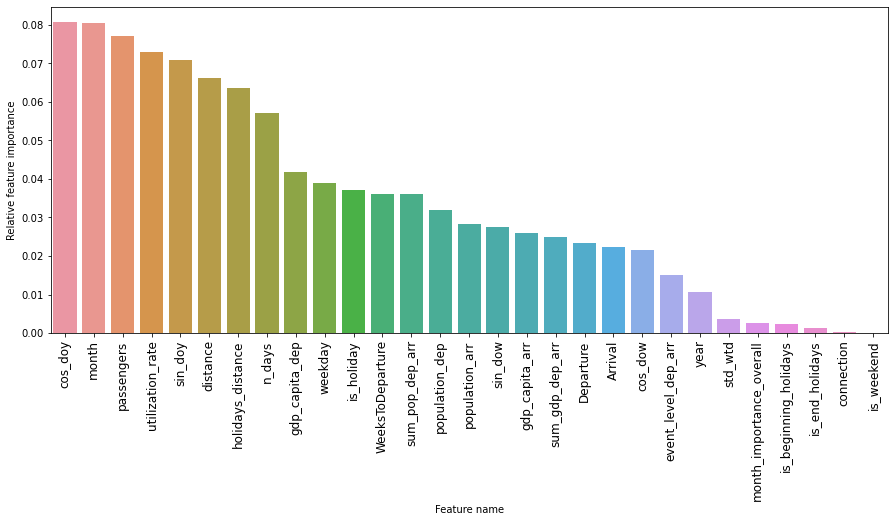

In [129]:
# plot feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x='feature_name', y='feature_importance', data=feature_imp.sort_values('feature_importance', ascending=False))
plt.ylabel('Relative feature importance')
plt.xlabel('Feature name')
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [71]:
scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

In [72]:
print('Average RMSE over 3 folds %.5f +/- %.5f' % (np.sqrt(-np.mean(scores)), np.std(scores)))

Average RMSE over 3 folds 0.33401 +/- 0.00102


In [68]:
test_rmse = np.sqrt(mean_squared_error(pipeline.predict(X_test), y_test))
print('Test RMSE:', test_rmse)

Test RMSE: 0.31101107690998


## XGBoost

In [60]:
pipeline = get_estimator('xgb')
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer-1',
                                  FunctionTransformer(func=<function _merge_external_data at 0x7ff8f1df9ee0>)),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=<function _encode_dates at 0x7ff8f1f035e0>))])),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_esti

In [151]:
feature_imp = pd.DataFrame({'feature_name': pipeline[0].fit_transform(X_train).columns,
                           'feature_importance': pipeline[2].feature_importances_/pipeline[2].feature_importances_.sum()})

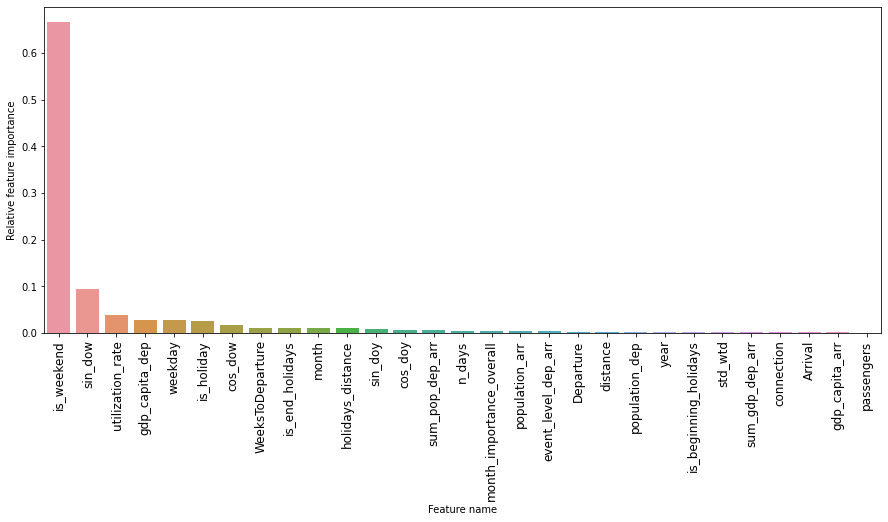

In [152]:
# plot feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x='feature_name', y='feature_importance', data=feature_imp.sort_values('feature_importance', ascending=False))
plt.ylabel('Relative feature importance')
plt.xlabel('Feature name')
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [61]:
scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')

In [62]:
print('Average RMSE over 3 folds %.5f +/- %.5f' % (np.sqrt(-np.mean(scores)), np.std(scores)))

Average RMSE over 3 folds 0.36613 +/- 0.00583


In [155]:
test_rmse = np.sqrt(mean_squared_error(pipeline.predict(X_test), y_test))
print('Test RMSE:', test_rmse)

Test RMSE: 0.32518193549243385


## Catboost

In [41]:
X_train_preprocessed = pipeline[0].transform(X_train)

In [39]:
categorical_cols = ['Departure', 'Arrival', 'connection']
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=False, cat_features=categorical_cols,
                             one_hot_max_size=10)

X_train_preprocessed.loc[:, 'event_level_dep_arr'] = X_train_preprocessed.loc[:, 'event_level_dep_arr'].astype('int')
cat_model.fit(X_train_preprocessed, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [164]:
feature_imp = pd.DataFrame({'feature_name': pipeline[0].fit_transform(X_train).columns,
                           'feature_importance': cat_model.feature_importances_/cat_model.feature_importances_.sum()})

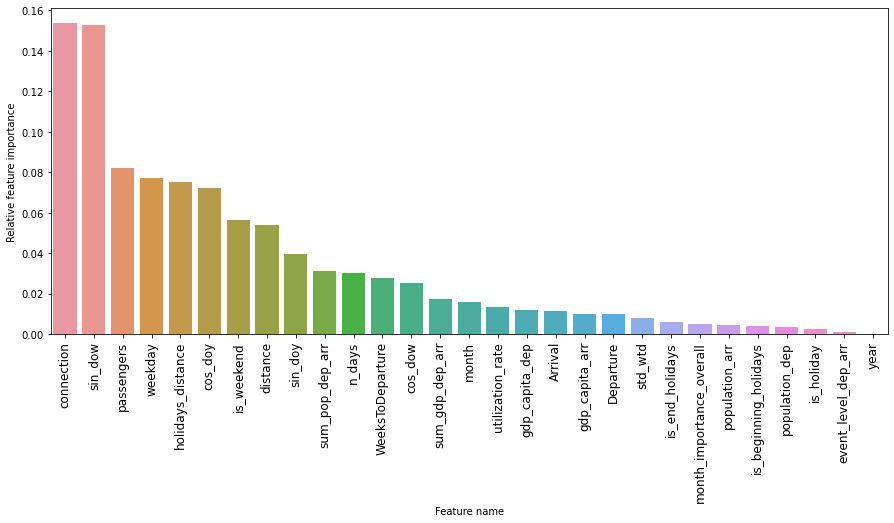

In [165]:
# plot feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x='feature_name', y='feature_importance', data=feature_imp.sort_values('feature_importance', ascending=False))
plt.ylabel('Relative feature importance')
plt.xlabel('Feature name')
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [172]:
print('Number of trees in the model:', cat_model.tree_count_)
print('Best RMSE: %.3f' % cat_model.best_score_['learn']['RMSE'])

Number of trees in the model: 1000
Best RMSE: 0.231


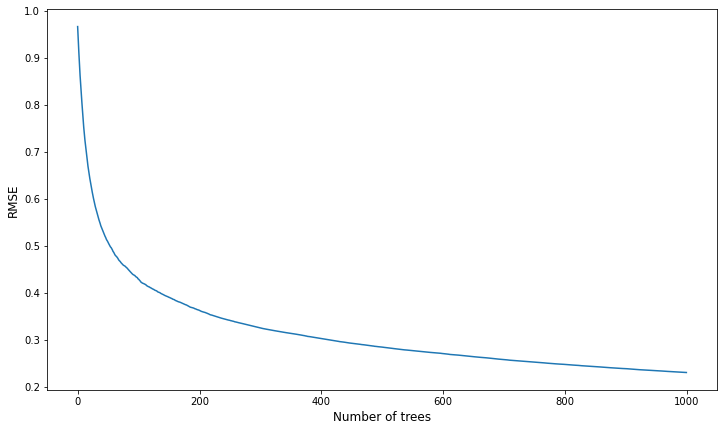

In [183]:
plt.figure(figsize=(12, 7))
plt.xlabel('Number of trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.plot(cat_model.evals_result_['learn']['RMSE'])
plt.show()

In [184]:
scores = cross_val_score(cat_model, X_train_preprocessed, y_train, cv=3, scoring='neg_mean_squared_error')
print('Average RMSE over 3 folds %.5f +/- %.5f' % (np.sqrt(-np.mean(scores)), np.std(scores)))

Average RMSE over 3 folds 0.32964 +/- 0.00028


In [52]:
X_test_preprocessed = pipeline[0].transform(X_test)
X_test_preprocessed.loc[:, 'event_level_dep_arr'] = X_test_preprocessed.loc[:, 'event_level_dep_arr'].astype('int')

In [192]:
test_rmse = np.sqrt(mean_squared_error(cat_model.predict(X_test_preprocessed), y_test))
print('Test RMSE:', test_rmse)

Test RMSE: 0.3109605242098963


## Permutation importance for Catboost

In [42]:
from sklearn.inspection import permutation_importance
result_train = permutation_importance(cat_model, X_train_preprocessed, y_train, n_repeats=10,
                              random_state=0)

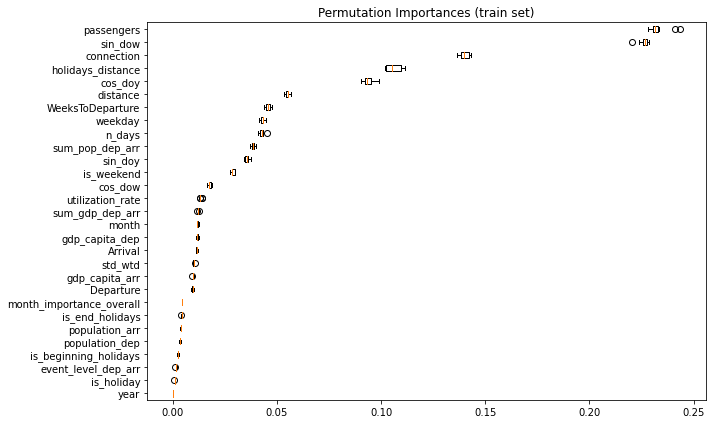

In [51]:
sorted_idx = result_train.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(result_train.importances[sorted_idx].T,
           vert=False, labels=X_train_preprocessed.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [53]:
result_test = permutation_importance(cat_model, X_test_preprocessed, y_test, n_repeats=10,
                              random_state=0)

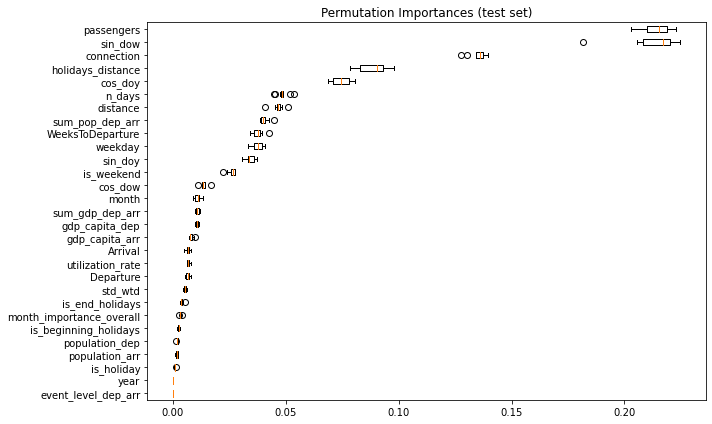

In [55]:
sorted_idx = result_test.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(result_test.importances[sorted_idx].T,
           vert=False, labels=X_test_preprocessed.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()